## Step 0: Importing modules

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

c:\Users\basic\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\basic\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Step 1: Statistical Arbitrage -- Pairs Trading

Pairs trading is a form of statistical arbitrage that assumes that the prices of highly cointegrated assets/stocks (such as those in the same industry with similar size and business models) will most often move in the same direction together, and that large temporary divergences in their prices/returns will revert back. 

To begin pairs trading, we first need to identify two highly cointegrated stocks. Cointegration is a measure of how much two time series move together and remain close to each other over time.

Some code modified from FINM 25000.

In [3]:
from statsmodels.tsa.stattools import coint


In [24]:
coca_cola_price = yf.download("KO", start="2014-01-01", end="2024-01-01")['Adj Close']
pepsico_price = yf.download("PEP", start="2014-01-01", end="2024-01-01")['Adj Close']

pairs_trading_data = pd.DataFrame({"KO": coca_cola_price["KO"], "PEP": pepsico_price["PEP"]}).dropna()


score, pvalue, _ = coint(pairs_trading_data["KO"], pairs_trading_data["PEP"])
print(f'P-value: {pvalue}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

P-value: 0.0028529707341931453


<Axes: xlabel='Date'>

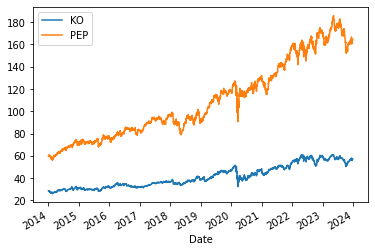

In [26]:
pairs_trading_data.plot()

Here we see that the prices of Coca Cola (KO) and PepsiCo (PEP) are statistically cointegrated with a p-value of < 0.05 (it helps that we chose a large timeframe considering we are using daily prices).

Now we can calulate the spread of their prices and calculate a rolling z-score of the spread (we will use a 30 day timeframe) for use in deriving our trading signals.

In [32]:
pairs_trading_data["spread"] = pairs_trading_data["PEP"] - pairs_trading_data["KO"]
pairs_trading_data["rolling_zscore"] = (pairs_trading_data["spread"] - pairs_trading_data["spread"].rolling(30).mean()) / pairs_trading_data["spread"].rolling(30).std()

<Axes: xlabel='Date'>

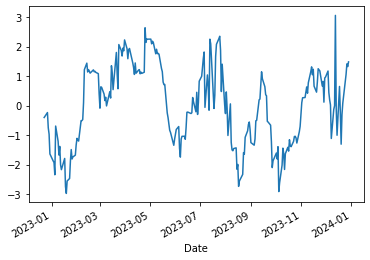

In [33]:
pairs_trading_data["rolling_zscore"].tail(255).plot() # Plot last year rolling z-score

Now we can define our trading signals. When the spread's Z-score is below -1, that means that the spread is unusually small, and we can expect it to increase to it's usual level (hence go long the pricier stock PEP). When the spread's Z-score is above 1, it is unusually large, so we can expect it to decrease to it's usual level (hence go short the pricier stock PEP).

In [34]:
pairs_trading_data["long_signal"] = np.where(pairs_trading_data["rolling_zscore"] < -1, 1, 0)
pairs_trading_data["short_signal"] = np.where(pairs_trading_data["rolling_zscore"] > 1, -1, 0)
pairs_trading_data["signal"] = pairs_trading_data["long_signal"] + pairs_trading_data["short_signal"]

In [35]:
pairs_trading_data

,KO,PEP,spread,rolling_zscore,long_signal,short_signal,signal
Date,,,,,,,
2014-01-02,28.724308,59.668812,30.944504,NaN,0,0,0
2014-01-03,28.583008,59.770580,31.187572,NaN,0,0,0
2014-01-06,28.448790,59.799629,31.350840,NaN,0,0,0
2014-01-07,28.533564,60.671772,32.138208,NaN,0,0,0
2014-01-08,28.215668,60.497345,32.281677,NaN,0,0,0
...,...,...,...,...,...,...,...
2023-12-22,56.591599,162.476974,105.885376,0.082703,0,0,0
2023-12-26,56.824493,163.620377,106.795883,1.057528,0,-1,-1
2023-12-27,56.970043,164.143616,107.173573,1.414148,0,-1,-1


Now we can simulate a backtest (since we are using rolling only):

In [38]:
pairs_trading_data['Return'] = pairs_trading_data["PEP"].pct_change() * pairs_trading_data['signal'].shift() # Remember we are going long/short KP. We could also go short/long PEP correspondingly
pairs_trading_data['Total Return'] = (1 + pairs_trading_data['Return']).cumprod()


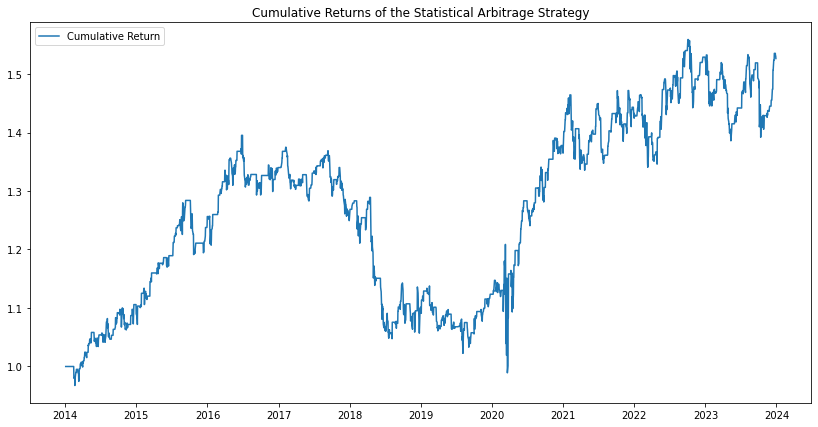

In [41]:
plt.figure(figsize=(14, 7))
plt.plot(pairs_trading_data.index, pairs_trading_data['Total Return'], label='Cumulative Return')
plt.title('Cumulative Returns of the Statistical Arbitrage Strategy')
plt.legend()
plt.show()

TODO (Optional): Calculate the mean annual returns and sharpe ratio of the strategy. HINT: Remember to consider the timeframe we are operating on and the number of trading days in a year!

TODO 2 (Optional): Now that you have a basic metric to analyze the strategy's performance, play around with the strategy (finding different pairs, changing rolling z-score window size, zscore threshold, etc.) to try and find a better sharpe configuration of this strategy based on a sound backtest.

## Step 2: Trend/Momentum Trading

Momentum trading is a trading strategy that relies on identifying short-term momentum towards an upwards or downwards movement in price, following that trend, and then identifying the eventual decrease in momentum to close the position before it reverses. 

In this example, we will use Exponential Moving Average crossover to idenify our trends in a common stock known for it's hype (TSLA), attempting to capitalize on the "investor herding". When out long-term EMA crosses below our short-term EMA, it will give a signal for a buy opportunity (why does this make sense?), and vice-versa. We are going to use an EMA so that more recent prices are given more weight, as investors heuristically give more importance to more recent price data.

An EMA of 12 and 26 days are used in "textbook" examples, but feel free to play around with them in your backtest to see what works.

NOTE: TSLA has had pretty remarkable returns in the last few years. When analyzing the performance of our strategy, we also want to consider it in comparison to just holding the asset outright, compare it to the market as a whole, and compare risk-adjusted metrics such as sharpe ratio as well. 

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

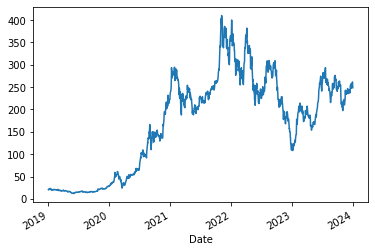

In [43]:
tsla_price = yf.download("TSLA", start="2019-01-01", end="2024-01-01")['Adj Close']
tsla_price["TSLA"].plot()

Let's calculate our EMAs and their corresponding signals

C:\Users\basic\AppData\Local\Temp\ipykernel_5388\2688282774.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tsla_price['signal'][12:] = np.where(tsla_price['ema12'][12:] > tsla_price['ema26'][12:], 1.0, 0.0)


<Axes: xlabel='Date'>

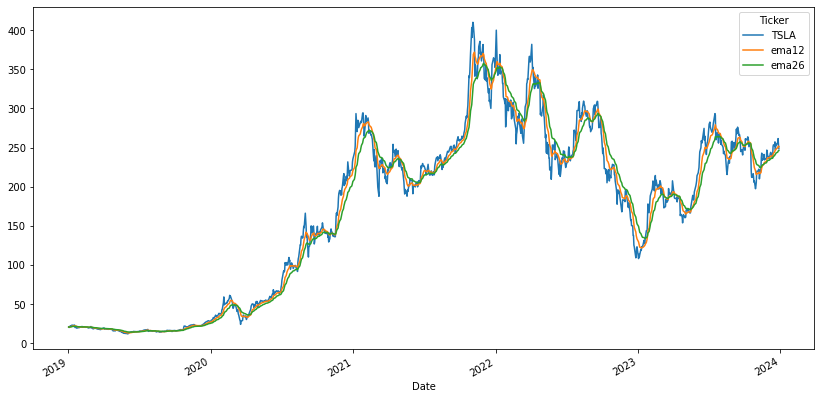

In [46]:
# Code modified from FINM 25000

tsla_price['ema12'] = tsla_price['TSLA'].ewm(span=12, adjust=False).mean()
tsla_price['ema26'] = tsla_price['TSLA'].ewm(span=26, adjust=False).mean()

tsla_price['signal'] = 0.0
tsla_price['signal'][12:] = np.where(tsla_price['ema12'][12:] > tsla_price['ema26'][12:], 1.0, 0.0)
tsla_price['position'] = tsla_price['signal'].diff()

tsla_price[['TSLA', 'ema12', 'ema26']].plot(figsize=(14, 7))

Now we can backtest our returns

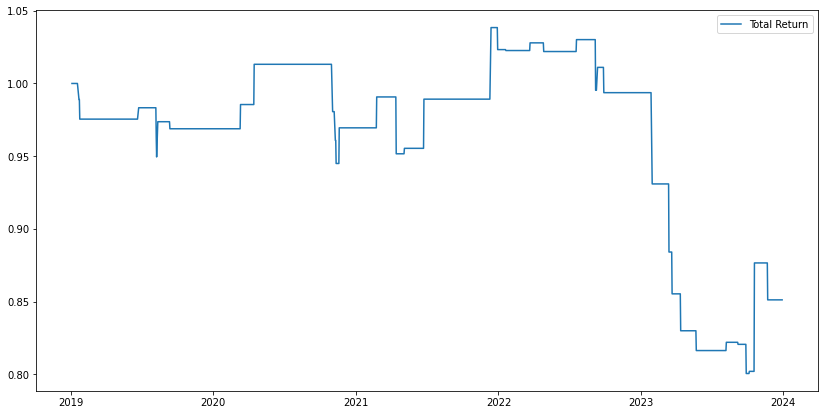

In [47]:
tsla_price['return'] = tsla_price['TSLA'].pct_change()
tsla_price['position returns'] = tsla_price['return'] * tsla_price['position'].shift()

# Plot cumulative returns of the strategy
tsla_price['Total Return'] = (1 + tsla_price['position returns']).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(tsla_price['Total Return'], label='Total Return')
plt.legend()
plt.show()

Oh no! We lost money! Unfortunately, one cannot just take simple strategies with a loose hypothesis and little due dilligance and expect to make money! Momentum trading can be a lucrative strategy when done right, but there is no one size fits all strategy for any asset (otherwise I'd be a billionaire).

## Step 3: Technical Indicator Examples (Erik)

In [48]:
# Fetch historical stock data
msft = yf.download("MSFT", start="2020-01-01", end="2025-01-01")

# Simple Moving Average
def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

msft['SMA_50'] = calculate_sma(msft['Close'], 50)

[*********************100%***********************]  1 of 1 completed


In [49]:
def calculate_ema(prices, window):
    alpha = 2 / (window + 1)
    ema = prices.copy()  # Initialize EMA with prices
    for i in range(1, len(prices)):
        ema.iloc[i] = (prices.iloc[i] * alpha) + (ema.iloc[i-1] * (1 - alpha))
    return ema

msft['EMA_20'] = calculate_ema(msft['Close'], 20)

In [50]:
def calculate_rsi(prices, window):
    delta = prices.diff()
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)

    avg_gain = gains.rolling(window=window).mean()
    avg_loss = losses.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

msft['RSI'] = calculate_rsi(msft['Close'], 14)

In [51]:
def calculate_macd(prices, fast=12, slow=26, signal=9):
    ema_fast = calculate_ema(prices, fast)
    ema_slow = calculate_ema(prices, slow)
    macd = ema_fast - ema_slow
    macd_signal = calculate_ema(macd, signal)
    macd_histogram = macd - macd_signal
    return macd, macd_signal, macd_histogram

msft['MACD'], msft['MACD_Signal'], msft['MACD_Hist'] = calculate_macd(msft['Close'])

In [52]:
def calculate_bollinger_bands(prices, window, num_std_dev):
    sma = calculate_sma(prices, window)
    rolling_std = prices.rolling(window=window).std()
    upper_band = sma + (rolling_std * num_std_dev)
    lower_band = sma - (rolling_std * num_std_dev)
    return sma, upper_band, lower_band

msft['BB_Middle'], msft['BB_Upper'], msft['BB_Lower'] = calculate_bollinger_bands(msft['Close'], 20, 2)


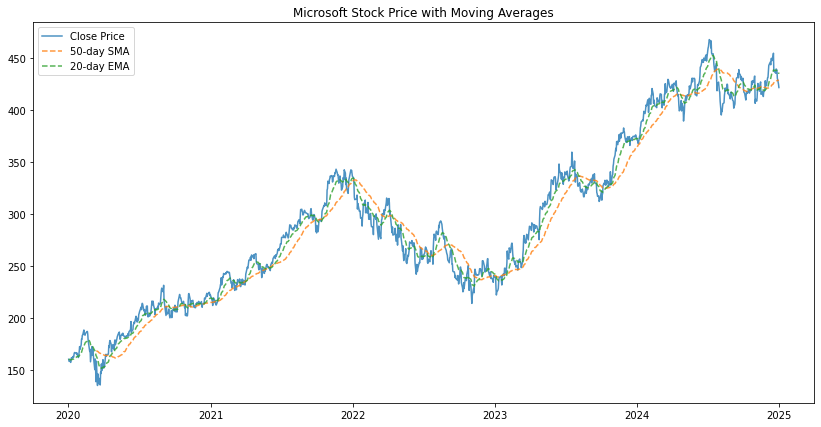

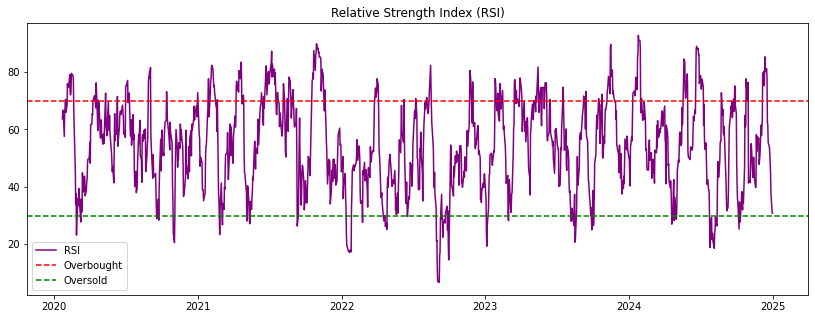

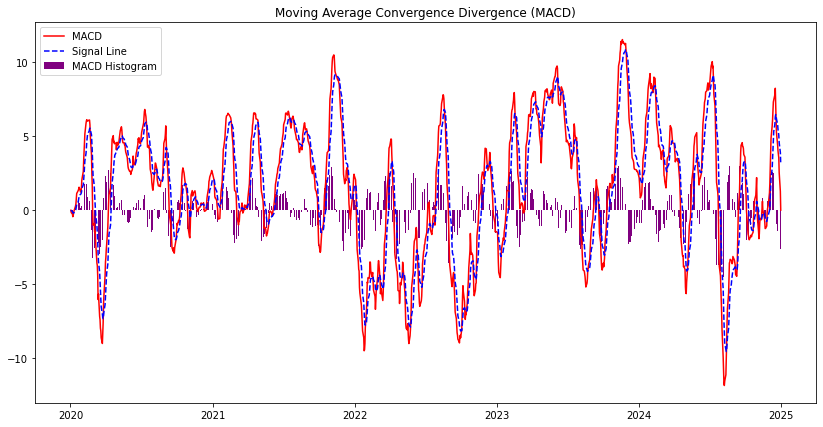

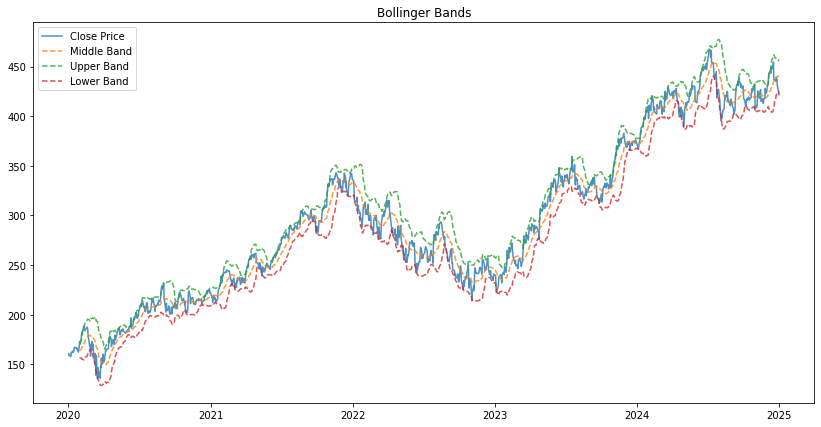

In [54]:
# Plotting the stock price with SMA and EMA
plt.figure(figsize=(14, 7))
plt.plot(msft['Close'], label='Close Price', alpha=0.8)
plt.plot(msft['SMA_50'], label='50-day SMA', linestyle='--', alpha=0.8)
plt.plot(msft['EMA_20'], label='20-day EMA', linestyle='--', alpha=0.8)
plt.title("Microsoft Stock Price with Moving Averages")
plt.legend()
plt.show()

# Plot RSI
plt.figure(figsize=(14, 5))
plt.plot(msft['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title("Relative Strength Index (RSI)")
plt.legend()
plt.show()

# Plot MACD
plt.figure(figsize=(14, 7))
plt.plot(msft['MACD'], label='MACD', color='red')
plt.plot(msft['MACD_Signal'], label='Signal Line', color='blue', linestyle='--')
plt.bar(msft.index, msft['MACD_Hist'], label='MACD Histogram', color='purple')
plt.title("Moving Average Convergence Divergence (MACD)")
plt.legend()
plt.show()

# Plot Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(msft['Close'], label='Close Price', alpha=0.8)
plt.plot(msft['BB_Middle'], label='Middle Band', linestyle='--', alpha=0.8)
plt.plot(msft['BB_Upper'], label='Upper Band', linestyle='--', alpha=0.8)
plt.plot(msft['BB_Lower'], label='Lower Band', linestyle='--', alpha=0.8)
plt.title("Bollinger Bands")
plt.legend()
plt.show()

## Step 4: Implement your own TI

Find a TI you think you would be able to implement, and do it for a stock of your choice.

(Optional) Simulate a trading strategy based on that TI.